In [1]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 1.25MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 6.56MB/s]


100%|██████████| 98.1M/98.1M [00:01<00:00, 84.6MB/s]


100%|██████████| 90.2M/90.2M [00:01<00:00, 55.6MB/s]


In [4]:

import numpy as np
import matplotlib.pyplot as plt

def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Ensure images are in the correct format for display
    images = images.numpy()  # Convert tensor to NumPy array

    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot each image individually
            ax.imshow(images[i])  # Display each image
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=10)
        else:
            ax.axis("off")  # Turn off axis if there are more subplots than images

    plt.tight_layout()
    plt.show()


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [24]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,  # Load one image at a time to get the exact count
    label_mode='int'
)

# Count the number of images
num_images = sum(1 for _ in dataset)
print(f"Total number of images in the dataset: {num_images}")


Found 32 files belonging to 4 classes.
Total number of images in the dataset: 32


In [16]:
train_accuracy_history = []
val_accuracy_history = []
EPOCHS = 5

total_images = num_images
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)


Found 32 files belonging to 4 classes.
Total number of images in the dataset: 32


Found 32 files belonging to 4 classes.

Training fold 1...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - accuracy: 0.3200 - loss: 1.3957 - val_accuracy: 0.4286 - val_loss: 1.3729
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - accuracy: 0.1600 - loss: 1.3916 - val_accuracy: 0.4286 - val_loss: 1.3990
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.2400 - loss: 1.3904 - val_accuracy: 0.2857 - val_loss: 1.3913
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.2000 - loss: 1.3788 - val_accuracy: 0.2857 - val_loss: 1.3564
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.3600 - loss: 1.3691 - val_accuracy: 0.2857 - val_loss: 1.3504
Fold 1 - Validation Accuracy: 0.2857142984867096

Training fold 2...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - accuracy: 0.0800 - loss: 1.4010 - val_accuracy: 0.4286 - val_loss: 1.3365
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.2000 - loss: 1.3873 - val_accuracy: 0.4286 - val_loss: 1.3677
Epoc

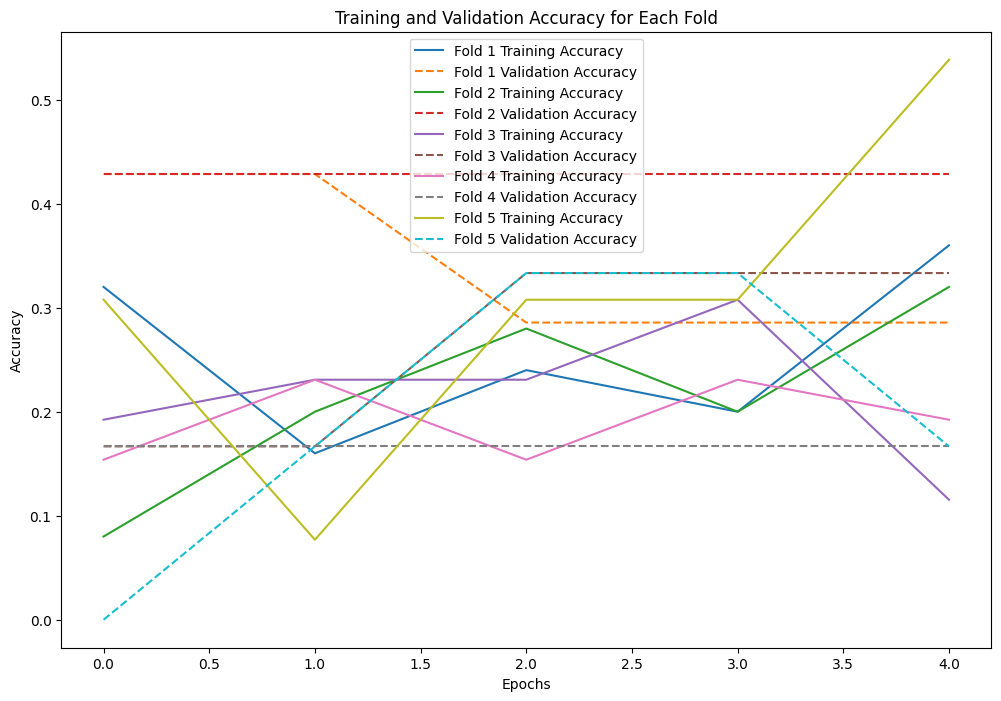

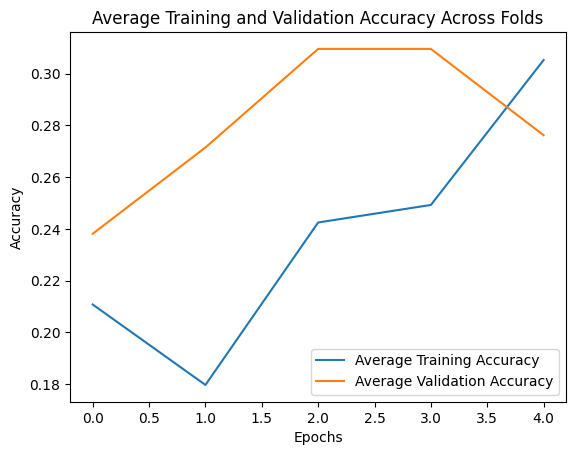

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - accuracy: 0.4375 - loss: 1.3287
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - accuracy: 0.4688 - loss: 1.3185
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.4062 - loss: 1.3090
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.5938 - loss: 1.2956
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - accuracy: 0.6250 - loss: 1.2988


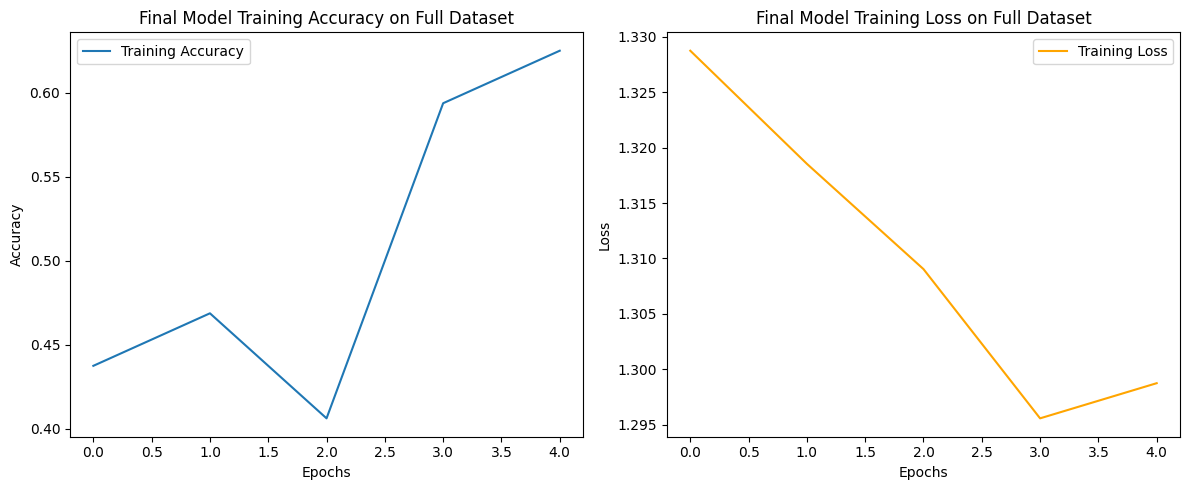

In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5

# Load the entire dataset without validation split (for manual cross-validation splitting later)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,  # Load one image at a time to avoid automatic batching
    label_mode='int'
)

# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define KFold cross-validator
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0  # Track the best validation accuracy
best_weights = None    # Placeholder for best model weights


train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using the Functional API

    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4 , trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        # optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )

    # Train the model on this fold
    history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

    # Append accuracy histories for each fold
    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])

    # Get the validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    # Check if this fold's model is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()  # Save the weights of the best model

    fold_no += 1


# Convert lists to numpy arrays for easier averaging
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# After cross-validation, create a new model and load the best weights
final_model = keras.Model(inputs=inputs, outputs=outputs)  # Same architecture as before
final_model.set_weights(best_weights)  # Load best weights from cross-validation

# Compile the final model
final_model.compile(
    loss="sparse_categorical_crossentropy",
    # optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

# Combine the full dataset for fine-tuning
full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.map(lambda x, y: (x / 255.0, y))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Fine-tune the model on the full dataset
history =  final_model.fit(full_train_dataset, epochs=5)

# Plot training accuracy and loss for the final model
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Load the test dataset from directory
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

# Normalize the test dataset
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))  # Scale pixel values to [0, 1]


Found 32 files belonging to 4 classes.


In [9]:
# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2188 - loss: 1.4009

Test Loss: 1.400948405265808
Test Accuracy: 0.21875


In [19]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Convert images to uint8 and ensure values are in the range [0, 255]
    processed_images = [(image * 255).astype("uint8") if image.max() <= 1 else image.astype("uint8") for image in images]

    num_images = len(processed_images)
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(processed_images[i])  # Display the processed image
        plt.axis("off")

        if titles is not None:
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


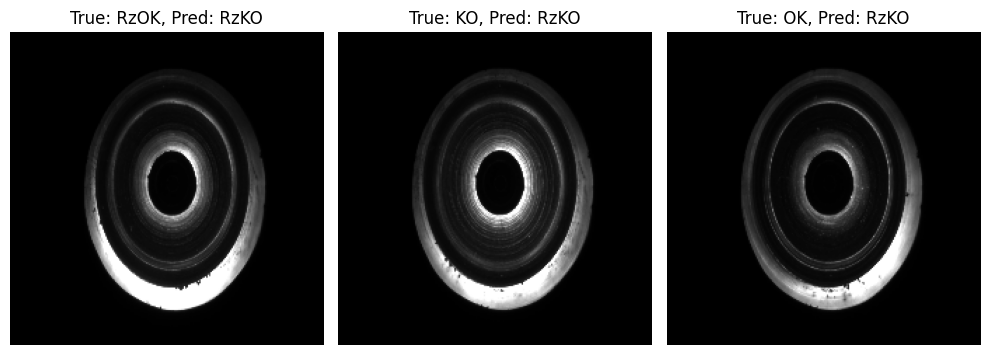

In [20]:
import matplotlib.pyplot as plt

# Lists to store misclassified images and their labels
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Go through the test dataset to identify misclassified images
for images, labels in test_dataset:
    predictions = final_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Ensure data types are compatible for comparison
    labels = tf.cast(labels, tf.int64)
    predicted_labels = tf.cast(predicted_labels, tf.int64)

    # Check for misclassifications
    for i in range(len(labels)):
        if predicted_labels[i] != labels[i]:  # Misclassified
            misclassified_images.append(images[i].numpy())  # Store the image
            misclassified_true_labels.append(labels[i].numpy())  # True label
            misclassified_pred_labels.append(predicted_labels[i].numpy())  # Predicted label

    # Stop once we have enough misclassified samples (e.g., 3 or more)
    if len(misclassified_images) >= 3:
        break

# Prepare titles with true and predicted labels for the first 3 misclassifications
titles = [
    f"True: {class_names[misclassified_true_labels[i]]}, Pred: {class_names[misclassified_pred_labels[i]]}"
    for i in range(3)
]

# Plot the first 3 misclassified images using plot_image_gallery
plot_image_gallery(misclassified_images[:3], titles=titles)
